In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np
from copy import deepcopy

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are used:
* **resize**
* **center crop**
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std according to ImageNet

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * resize images,
        * center crop images,
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std according to ImageNet
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. GoogLeNet

We'll use the **pretrained version** of GoogLeNet. Since CIFAR-10 dataset has less classes than ImageNet, we'll keep all the layers **freezed**, except of the last one, which will be **unfreezed** and updated with the right number of classes and will be re-trained.

![GoogLeNet](images\googlenet.png)

Regularization:
* Weight decay (L2 regularization)

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    """ This helper function sets the .requires_grad attribute of the parameters in the model 
    to False when we are feature extracting. 
    
    When we are feature extracting and only want to compute gradients for the newly initialized layer, 
    then we want all of the other parameters to not require gradients.
    
    Args:
        model: 
            deep learning model, as pytorch object.
        feature_extracting:
            whether or not we're feature extracting, as boolean.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(num_labels, feature_extracting, pretrained=True):
    """ Initialize GoogLeNet model and reshape the last layer with the correct number of classes.
    
    Since GoogLeNet has been pretrained on Imagenet, it has output layers of size 1000, one node for each class. 
    We reshape the last layer to have the same number of inputs as before, and to have the same number of 
    outputs as the number of classes in our the dataset.
    
    Args:
        num_labels:
            number of labels in our dataset, as integer.
        feature_extracting:
          flag for feature extracting (when False, we finetune the whole model, 
          when True we only update the reshaped layer params), as boolean.
        pretrained:
            whether or not we want the pretrained version of AlexNet, as boolean.
    
    Returns:
        GoogLeNet model, as pytorch object
    """
    model = models.googlenet(pretrained=pretrained)
    
    set_parameter_requires_grad(model, feature_extracting)
    
    last_layer_in_ftrs = model.fc.in_features
    model.fc = nn.Linear(last_layer_in_ftrs, num_labels)
    
    return model

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                                  | Validation Loss | Validation Accuracy |
| :------------------------------: | :-------------: | :-----------------: |
| GoogLeNet                        | 0.51            | 81%                 |

Best trial **configuration** for GoogLeNet: lr: 0.001, l2: 0.0001

In [7]:
def tune_helper(config, trainset, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    feature_extracting = True
    pretrained = True
    model = initialize_model(num_labels=num_labels, 
                             feature_extracting=feature_extracting, 
                             pretrained=pretrained)
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # create an optimizer that only updates the desired parameters
    params_to_update = model.parameters()
    print("Parameters to learn:")
    if feature_extracting:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
    
    # optimizer
    optimizer = AdamW(params_to_update, lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [8]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper,
                                           trainset=trainset,
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [9]:
# hyperparameter search space
config = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4])
    }

In [10]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=30,
                    num_samples=1, 
                    cpus_per_trial=0,
                    gpus_per_trial=1)

Files already downloaded and verified
Files already downloaded and verified


2021-09-06 11:17:56,458	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-09-06 11:18:09,140	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-09-06 11:18:10,012	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (4 PENDING)
+-------------------------+----------+-------+--------+--------+
| Trial name              | status   | loc   |     l2 |     lr |
|-------------------------+----------+-------+--------+--------|
| tune_helper_f841d_00000 | PENDING  |       | 0.001  | 0.001  |
| tune_helper_f841d_00001 | PENDING  |       | 0.0001 | 0.001  |
| tune_helper_f841d_00002 | PENDING  |       | 0.001  | 0.0001 |
| tune_helper_f841d_00003 | PENDING  |       | 0.0001 | 0.0001 |
+-------------------------+----------+-------+--------+--------+


== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested

(pid=11860) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=11860)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_f841d_00000:
  accuracy: 0.7853
  date: 2021-09-06_11-21-54
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.656528340023794
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 223.08815383911133
  time_this_iter_s: 223.08815383911133
  time_total_s: 223.08815383911133
  timestamp: 1630916514
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+-

Result for tune_helper_f841d_00000:
  accuracy: 0.8075
  date: 2021-09-06_11-37-21
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.5595943747432368
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 1149.8485689163208
  time_this_iter_s: 184.69032740592957
  time_total_s: 1149.8485689163208
  timestamp: 1630917441
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+

Result for tune_helper_f841d_00000:
  accuracy: 0.8119
  date: 2021-09-06_11-52-45
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.5519983795038454
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 2073.7367565631866
  time_this_iter_s: 184.36194705963135
  time_total_s: 2073.7367565631866
  timestamp: 1630918365
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+-------

Result for tune_helper_f841d_00000:
  accuracy: 0.812
  date: 2021-09-06_12-08-10
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.5450651594407999
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 2998.9463868141174
  time_this_iter_s: 184.69080901145935
  time_total_s: 2998.9463868141174
  timestamp: 1630919290
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------

Result for tune_helper_f841d_00000:
  accuracy: 0.8178
  date: 2021-09-06_12-23-37
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.5298940537461809
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 3925.9144220352173
  time_this_iter_s: 186.38368463516235
  time_total_s: 3925.9144220352173
  timestamp: 1630920217
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+-------

Result for tune_helper_f841d_00000:
  accuracy: 0.8138
  date: 2021-09-06_12-39-01
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.5393434971760792
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 4849.676687955856
  time_this_iter_s: 184.22650718688965
  time_total_s: 4849.676687955856
  timestamp: 1630921141
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+

Result for tune_helper_f841d_00000:
  accuracy: 0.8219
  date: 2021-09-06_12-54-23
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.519822579280586
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 5771.996064901352
  time_this_iter_s: 184.8068037033081
  time_total_s: 5771.996064901352
  timestamp: 1630922063
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+------------------

Result for tune_helper_f841d_00000:
  accuracy: 0.8206
  date: 2021-09-06_13-09-55
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.5187581462465274
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 6703.8416113853455
  time_this_iter_s: 185.04997277259827
  time_total_s: 6703.8416113853455
  timestamp: 1630922995
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------

Result for tune_helper_f841d_00000:
  accuracy: 0.8236
  date: 2021-09-06_13-25-18
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.515248352554953
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 7627.35578918457
  time_this_iter_s: 184.74929213523865
  time_total_s: 7627.35578918457
  timestamp: 1630923918
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------------

Result for tune_helper_f841d_00000:
  accuracy: 0.8207
  date: 2021-09-06_13-40-42
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.5225704407236379
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 8551.2393014431
  time_this_iter_s: 185.6055827140808
  time_total_s: 8551.2393014431
  timestamp: 1630924842
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+

Result for tune_helper_f841d_00000:
  accuracy: 0.8196
  date: 2021-09-06_13-56-08
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.5204472090977772
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 9476.398977279663
  time_this_iter_s: 184.40659141540527
  time_total_s: 9476.398977279663
  timestamp: 1630925768
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+----------------

Result for tune_helper_f841d_00000:
  accuracy: 0.8208
  date: 2021-09-06_14-11-35
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.51956748791561
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 10403.634903430939
  time_this_iter_s: 184.80572891235352
  time_total_s: 10403.634903430939
  timestamp: 1630926695
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+----------------

Result for tune_helper_f841d_00000:
  accuracy: 0.8208
  date: 2021-09-06_14-27-03
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.5244182857928003
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 11331.676627397537
  time_this_iter_s: 184.54056024551392
  time_total_s: 11331.676627397537
  timestamp: 1630927623
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_f841d_00000:
  accuracy: 0.8228
  date: 2021-09-06_14-42-27
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.5163957087477301
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 12256.19627404213
  time_this_iter_s: 184.5915069580078
  time_total_s: 12256.19627404213
  timestamp: 1630928547
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--

Result for tune_helper_f841d_00000:
  accuracy: 0.8223
  date: 2021-09-06_14-57-54
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.518298456053825
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 13183.129629135132
  time_this_iter_s: 185.14012932777405
  time_total_s: 13183.129629135132
  timestamp: 1630929474
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

Result for tune_helper_f841d_00000:
  accuracy: 0.8194
  date: 2021-09-06_15-13-28
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.5263574201210289
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 14117.246775150299
  time_this_iter_s: 185.5115463733673
  time_total_s: 14117.246775150299
  timestamp: 1630930408
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

Result for tune_helper_f841d_00000:
  accuracy: 0.8249
  date: 2021-09-06_15-28-54
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.5182505377158997
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 15042.697289943695
  time_this_iter_s: 184.92573833465576
  time_total_s: 15042.697289943695
  timestamp: 1630931334
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_f841d_00000:
  accuracy: 0.8232
  date: 2021-09-06_15-44-19
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.5184743499300283
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 15968.251798391342
  time_this_iter_s: 185.715261220932
  time_total_s: 15968.251798391342
  timestamp: 1630932259
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_f841d_00000:
  accuracy: 0.8213
  date: 2021-09-06_15-59-51
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.5164916465047059
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 16899.44336748123
  time_this_iter_s: 185.31877207756042
  time_total_s: 16899.44336748123
  timestamp: 1630933191
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_f841d_00000:
  accuracy: 0.8207
  date: 2021-09-06_16-15-17
  done: false
  experiment_id: ca2e5737be0444f8b6d9fb08781be1e8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.519337601532602
  node_ip: 192.168.1.22
  pid: 11860
  time_since_restore: 17825.808914899826
  time_this_iter_s: 185.61008143424988
  time_total_s: 17825.808914899826
  timestamp: 1630934117
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: f841d_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

(pid=11860) Windows fatal exception: access violation
(pid=11860) 


(pid=3400) Parameters to learn:
(pid=3400) 	 fc.weight
(pid=3400) 	 fc.bias


(pid=3400) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=3400)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_f841d_00001:
  accuracy: 0.7801
  date: 2021-09-06_16-31-13
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6639709990874977
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 195.50841116905212
  time_this_iter_s: 195.50841116905212
  time_total_s: 195.50841116905212
  timestamp: 1630935073
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8061
  date: 2021-09-06_16-46-39
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.5553623770072962
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 1121.2100648880005
  time_this_iter_s: 185.48762679100037
  time_total_s: 1121.2100648880005
  timestamp: 1630935999
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8055
  date: 2021-09-06_17-02-06
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.5562170605370953
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 2047.9340090751648
  time_this_iter_s: 185.06814551353455
  time_total_s: 2047.9340090751648
  timestamp: 1630936926
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8053
  date: 2021-09-06_17-17-29
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.5427885942967834
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 2971.675808429718
  time_this_iter_s: 184.46112442016602
  time_total_s: 2971.675808429718
  timestamp: 1630937849
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8115
  date: 2021-09-06_17-32-56
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.5337041052663403
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 3897.900490283966
  time_this_iter_s: 185.50626921653748
  time_total_s: 3897.900490283966
  timestamp: 1630938776
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8139
  date: 2021-09-06_17-48-20
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.5242622509883468
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 4822.567282915115
  time_this_iter_s: 184.99529027938843
  time_total_s: 4822.567282915115
  timestamp: 1630939700
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8144
  date: 2021-09-06_18-03-43
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.5242338262166187
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 5745.806665420532
  time_this_iter_s: 184.28598260879517
  time_total_s: 5745.806665420532
  timestamp: 1630940623
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8147
  date: 2021-09-06_18-19-09
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.530521322018022
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 6671.259689569473
  time_this_iter_s: 185.55153250694275
  time_total_s: 6671.259689569473
  timestamp: 1630941549
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8112
  date: 2021-09-06_18-34-34
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.5355217052493125
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 7596.46918964386
  time_this_iter_s: 184.51607012748718
  time_total_s: 7596.46918964386
  timestamp: 1630942474
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+

Result for tune_helper_f841d_00001:
  accuracy: 0.8161
  date: 2021-09-06_18-50-02
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.5177433210763203
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 8524.796738862991
  time_this_iter_s: 186.38561463356018
  time_total_s: 8524.796738862991
  timestamp: 1630943402
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8172
  date: 2021-09-06_19-05-33
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.5206949994632393
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 9455.080250501633
  time_this_iter_s: 185.94380235671997
  time_total_s: 9455.080250501633
  timestamp: 1630944333
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8179
  date: 2021-09-06_19-21-02
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.516384213878091
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 10384.370768547058
  time_this_iter_s: 185.94632983207703
  time_total_s: 10384.370768547058
  timestamp: 1630945262
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5239779875156986 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.819
  date: 2021-09-06_19-36-31
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.5177105105226967
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 11312.935144901276
  time_this_iter_s: 185.4577558040619
  time_total_s: 11312.935144901276
  timestamp: 1630946191
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8152
  date: 2021-09-06_19-52-00
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.5203702865512507
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 12241.967222452164
  time_this_iter_s: 185.84657335281372
  time_total_s: 12241.967222452164
  timestamp: 1630947120
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8157
  date: 2021-09-06_20-07-30
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.5274778414683737
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 13172.212513446808
  time_this_iter_s: 186.36969137191772
  time_total_s: 13172.212513446808
  timestamp: 1630948050
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8176
  date: 2021-09-06_20-23-01
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.5187112242932532
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 14103.762103319168
  time_this_iter_s: 185.9876708984375
  time_total_s: 14103.762103319168
  timestamp: 1630948981
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8168
  date: 2021-09-06_20-38-31
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.5200233617026335
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 15033.407722234726
  time_this_iter_s: 185.44119238853455
  time_total_s: 15033.407722234726
  timestamp: 1630949911
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8189
  date: 2021-09-06_20-54-00
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.5150868454176909
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 15962.507922649384
  time_this_iter_s: 186.14196729660034
  time_total_s: 15962.507922649384
  timestamp: 1630950840
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8173
  date: 2021-09-06_21-09-31
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.5212553479489247
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 16893.18027329445
  time_this_iter_s: 186.73371958732605
  time_total_s: 16893.18027329445
  timestamp: 1630951771
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_f841d_00001:
  accuracy: 0.8154
  date: 2021-09-06_21-25-00
  done: false
  experiment_id: 960f2a62d29c4eaf8d4ff73e32aba5a8
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.5190035121361162
  node_ip: 192.168.1.22
  pid: 3400
  time_since_restore: 17822.099406957626
  time_this_iter_s: 185.35580587387085
  time_total_s: 17822.099406957626
  timestamp: 1630952700
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: f841d_00001
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

(pid=3400) Windows fatal exception: access violation
(pid=3400) 


(pid=15368) Parameters to learn:
(pid=15368) 	 fc.weight
(pid=15368) 	 fc.bias


(pid=15368) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=15368)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_f841d_00002:
  accuracy: 0.7326
  date: 2021-09-06_21-40-37
  done: false
  experiment_id: 46b62e30b8a2408b97f22e2f9aec3046
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.2689090822912326
  node_ip: 192.168.1.22
  pid: 15368
  time_since_restore: 191.84318661689758
  time_this_iter_s: 191.84318661689758
  time_total_s: 191.84318661689758
  timestamp: 1630953637
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f841d_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_f841d_00002:
  accuracy: 0.7849
  date: 2021-09-06_21-56-00
  done: false
  experiment_id: 46b62e30b8a2408b97f22e2f9aec3046
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.6930490324072017
  node_ip: 192.168.1.22
  pid: 15368
  time_since_restore: 1114.763840675354
  time_this_iter_s: 184.28361058235168
  time_total_s: 1114.763840675354
  timestamp: 1630954560
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f841d_00002
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------

Result for tune_helper_f841d_00002:
  accuracy: 0.7974
  date: 2021-09-06_22-11-26
  done: false
  experiment_id: 46b62e30b8a2408b97f22e2f9aec3046
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.6183014373490765
  node_ip: 192.168.1.22
  pid: 15368
  time_since_restore: 2040.8891253471375
  time_this_iter_s: 185.5172038078308
  time_total_s: 2040.8891253471375
  timestamp: 1630955486
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f841d_00002
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_f841d_00002:
  accuracy: 0.8026
  date: 2021-09-06_22-26-50
  done: false
  experiment_id: 46b62e30b8a2408b97f22e2f9aec3046
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.5885298574806019
  node_ip: 192.168.1.22
  pid: 15368
  time_since_restore: 2965.3654749393463
  time_this_iter_s: 184.62946200370789
  time_total_s: 2965.3654749393463
  timestamp: 1630956410
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: f841d_00002
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_f841d_00002:
  accuracy: 0.8069
  date: 2021-09-06_22-42-14
  done: false
  experiment_id: 46b62e30b8a2408b97f22e2f9aec3046
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.5783437112714075
  node_ip: 192.168.1.22
  pid: 15368
  time_since_restore: 3889.563274383545
  time_this_iter_s: 184.62529969215393
  time_total_s: 3889.563274383545
  timestamp: 1630957334
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: f841d_00002
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_f841d_00002:
  accuracy: 0.8107
  date: 2021-09-06_22-57-37
  done: false
  experiment_id: 46b62e30b8a2408b97f22e2f9aec3046
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.5627028283419883
  node_ip: 192.168.1.22
  pid: 15368
  time_since_restore: 4812.358286380768
  time_this_iter_s: 184.2986307144165
  time_total_s: 4812.358286380768
  timestamp: 1630958257
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: f841d_00002
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.5324590357056089
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

(pid=15368) Windows fatal exception: access violation
(pid=15368) 


(pid=5704) Parameters to learn:
(pid=5704) 	 fc.weight
(pid=5704) 	 fc.bias


(pid=5704) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=5704)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_f841d_00003:
  accuracy: 0.7214
  date: 2021-09-06_23-13-41
  done: false
  experiment_id: 37f0acd19e304f99a3688e8057e3f907
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.2862561508348793
  node_ip: 192.168.1.22
  pid: 5704
  time_since_restore: 194.25316429138184
  time_this_iter_s: 194.25316429138184
  time_total_s: 194.25316429138184
  timestamp: 1630959221
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f841d_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_f841d_00003:
  accuracy: 0.7841
  date: 2021-09-06_23-29-07
  done: false
  experiment_id: 37f0acd19e304f99a3688e8057e3f907
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.6947734967158858
  node_ip: 192.168.1.22
  pid: 5704
  time_since_restore: 1121.0771491527557
  time_this_iter_s: 185.13407969474792
  time_total_s: 1121.0771491527557
  timestamp: 1630960147
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f841d_00003
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_f841d_00003:
  accuracy: 0.799
  date: 2021-09-06_23-44-33
  done: false
  experiment_id: 37f0acd19e304f99a3688e8057e3f907
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.6248364934496059
  node_ip: 192.168.1.22
  pid: 5704
  time_since_restore: 2046.6497461795807
  time_this_iter_s: 185.03929615020752
  time_total_s: 2046.6497461795807
  timestamp: 1630961073
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f841d_00003
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_f841d_00003:
  accuracy: 0.8058
  date: 2021-09-07_00-00-02
  done: false
  experiment_id: 37f0acd19e304f99a3688e8057e3f907
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.5938332587670369
  node_ip: 192.168.1.22
  pid: 5704
  time_since_restore: 2975.98578953743
  time_this_iter_s: 186.15957498550415
  time_total_s: 2975.98578953743
  timestamp: 1630962002
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: f841d_00003
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------------

Result for tune_helper_f841d_00003:
  accuracy: 0.8057
  date: 2021-09-07_00-15-43
  done: false
  experiment_id: 37f0acd19e304f99a3688e8057e3f907
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.58603204454586
  node_ip: 192.168.1.22
  pid: 5704
  time_since_restore: 3916.1687355041504
  time_this_iter_s: 191.091876745224
  time_total_s: 3916.1687355041504
  timestamp: 1630962943
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: f841d_00003
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------------

Result for tune_helper_f841d_00003:
  accuracy: 0.8082
  date: 2021-09-07_00-31-43
  done: false
  experiment_id: 37f0acd19e304f99a3688e8057e3f907
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.5748883183974369
  node_ip: 192.168.1.22
  pid: 5704
  time_since_restore: 4876.1661331653595
  time_this_iter_s: 198.94933938980103
  time_total_s: 4876.1661331653595
  timestamp: 1630963903
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: f841d_00003
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.5215097251496497 | Iter 30.000: -0.533363249081715
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/2.24 GiB heap, 0.0/1.12 GiB objects (0.0/1.0 GPU_group_0_a6b9282b5c722c3531288563550163a1, 0.0/1.0 GPU_group_a6b9282b5c722c3531288563550163a1)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-06_11-18-09
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

2021-09-07 00:44:15,242	INFO tune.py:550 -- Total run time: 48366.10 seconds (48365.05 seconds for the tuning loop).
(pid=5704) Windows fatal exception: access violation
(pid=5704) 


Best trial config: {'lr': 0.001, 'l2': 0.0001}
Best trial final validation loss: 0.5167661381375258
Best trial final validation acurracy: 0.8186


# 4. Fit and Predict

In [11]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [12]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
            
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: lr: 0.001, l2: 0.0001

Results: 
* Best **epoch**: 78
* Best **train**: **accuracy**: 84.2%, **avg loss**: 0.461243
* Best **test**: **accuracy**: 81.8%, **avg loss**: 0.517447

In [13]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [15]:
num_labels = 10
feature_extracting = True
pretrained = True

model = initialize_model(num_labels=num_labels, 
                         feature_extracting=feature_extracting, 
                         pretrained=pretrained).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1

Create an optimizer that **only** updates the desired parameters

In [16]:
learning_rate = 0.001
weight_decay = 0.0001

params_to_update = model.parameters()
print("Parameters to learn:")
if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# optimizer
optimizer = AdamW(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

# loss function
loss_fn = nn.CrossEntropyLoss()

Parameters to learn:
	 fc.weight
	 fc.bias


## 5.2 Fit and predict

In [17]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        if torch.cuda.is_available():
            model.to(torch.device("cpu"))
            best_model_state_dict = deepcopy(model.state_dict())
            model.to(device)
        else:
            best_model_state_dict = deepcopy(model.state_dict())
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------


C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.323838 [    0/50000]
loss: 0.878242 [ 6400/50000]
loss: 0.936324 [12800/50000]
loss: 1.073740 [19200/50000]
loss: 0.945656 [25600/50000]
loss: 0.864240 [32000/50000]
loss: 1.004353 [38400/50000]
loss: 0.877515 [44800/50000]

Train:
-------
accuracy: 79.3%, avg loss: 0.631315

Test:
-------
accuracy: 78.3%, avg loss: 0.652805

-------------------------------
Epoch 2
-------------------------------
loss: 0.696521 [    0/50000]
loss: 0.776797 [ 6400/50000]
loss: 0.961115 [12800/50000]
loss: 0.784033 [19200/50000]
loss: 0.678015 [25600/50000]
loss: 0.599257 [32000/50000]
loss: 0.701839 [38400/50000]
loss: 0.743948 [44800/50000]

Train:
-------
accuracy: 81.2%, avg loss: 0.561952

Test:
-------
accuracy: 80.0%, avg loss: 0.586950

-------------------------------
Epoch 3
-------------------------------
loss: 0.793306 [    0/50000]
loss: 0.731937 [ 6400/50000]
loss: 0.675727 [12800/50000]
loss: 0.643220 [19200/50000]
loss: 0.835842 [25600/50000]
loss: 0.537379 [32000/50000]
loss: 0.66

loss: 0.554122 [ 6400/50000]
loss: 0.595623 [12800/50000]
loss: 0.695365 [19200/50000]
loss: 0.478139 [25600/50000]
loss: 0.721665 [32000/50000]
loss: 0.749843 [38400/50000]
loss: 0.635737 [44800/50000]

Train:
-------
accuracy: 83.4%, avg loss: 0.479147

Test:
-------
accuracy: 80.8%, avg loss: 0.537136

-------------------------------
Epoch 22
-------------------------------
loss: 0.509765 [    0/50000]
loss: 0.552025 [ 6400/50000]
loss: 0.683769 [12800/50000]
loss: 0.623358 [19200/50000]
loss: 0.629467 [25600/50000]
loss: 0.698862 [32000/50000]
loss: 0.583071 [38400/50000]
loss: 0.651126 [44800/50000]

Train:
-------
accuracy: 83.0%, avg loss: 0.488532

Test:
-------
accuracy: 80.8%, avg loss: 0.546796

-------------------------------
Epoch 23
-------------------------------
loss: 0.639432 [    0/50000]
loss: 0.905740 [ 6400/50000]
loss: 0.393873 [12800/50000]
loss: 0.599288 [19200/50000]
loss: 0.591460 [25600/50000]
loss: 0.443613 [32000/50000]
loss: 0.331401 [38400/50000]
loss: 0.

loss: 0.562758 [12800/50000]
loss: 0.600785 [19200/50000]
loss: 0.755900 [25600/50000]
loss: 0.652784 [32000/50000]
loss: 0.478004 [38400/50000]
loss: 0.495541 [44800/50000]

Train:
-------
accuracy: 83.7%, avg loss: 0.472087

Test:
-------
accuracy: 81.1%, avg loss: 0.529164

-------------------------------
Epoch 42
-------------------------------
loss: 0.539068 [    0/50000]
loss: 0.669439 [ 6400/50000]
loss: 0.709060 [12800/50000]
loss: 0.519891 [19200/50000]
loss: 0.730881 [25600/50000]
loss: 0.576563 [32000/50000]
loss: 0.444133 [38400/50000]
loss: 0.564693 [44800/50000]

Train:
-------
accuracy: 83.7%, avg loss: 0.471273

Test:
-------
accuracy: 81.3%, avg loss: 0.529020

-------------------------------
Epoch 43
-------------------------------
loss: 1.009984 [    0/50000]
loss: 0.641115 [ 6400/50000]
loss: 0.592965 [12800/50000]
loss: 0.731929 [19200/50000]
loss: 0.596061 [25600/50000]
loss: 0.602143 [32000/50000]
loss: 0.908715 [38400/50000]
loss: 0.635760 [44800/50000]

Train:


loss: 0.642080 [19200/50000]
loss: 0.833649 [25600/50000]
loss: 0.682170 [32000/50000]
loss: 0.513949 [38400/50000]
loss: 0.522369 [44800/50000]

Train:
-------
accuracy: 84.1%, avg loss: 0.463676

Test:
-------
accuracy: 81.5%, avg loss: 0.520175

-------------------------------
Epoch 62
-------------------------------
loss: 0.788780 [    0/50000]
loss: 0.281046 [ 6400/50000]
loss: 0.647542 [12800/50000]
loss: 0.593293 [19200/50000]
loss: 0.567287 [25600/50000]
loss: 0.671679 [32000/50000]
loss: 0.452204 [38400/50000]
loss: 0.756396 [44800/50000]

Train:
-------
accuracy: 84.0%, avg loss: 0.465690

Test:
-------
accuracy: 81.6%, avg loss: 0.522188

-------------------------------
Epoch 63
-------------------------------
loss: 0.695576 [    0/50000]
loss: 0.533846 [ 6400/50000]
loss: 0.523279 [12800/50000]
loss: 0.719689 [19200/50000]
loss: 0.676501 [25600/50000]
loss: 0.513867 [32000/50000]
loss: 0.551840 [38400/50000]
loss: 0.820389 [44800/50000]

Train:
-------
accuracy: 83.9%, avg 

loss: 0.477264 [25600/50000]
loss: 0.490794 [32000/50000]
loss: 0.551205 [38400/50000]
loss: 0.520573 [44800/50000]

Train:
-------
accuracy: 84.0%, avg loss: 0.463896

Test:
-------
accuracy: 81.7%, avg loss: 0.522156

-------------------------------
Epoch 82
-------------------------------
loss: 0.700020 [    0/50000]
loss: 0.490310 [ 6400/50000]
loss: 0.494090 [12800/50000]
loss: 0.461532 [19200/50000]
loss: 0.545502 [25600/50000]
loss: 0.388644 [32000/50000]
loss: 0.497747 [38400/50000]
loss: 0.781295 [44800/50000]

Train:
-------
accuracy: 83.7%, avg loss: 0.471324

Test:
-------
accuracy: 81.4%, avg loss: 0.528001

-------------------------------
Epoch 83
-------------------------------
loss: 0.410812 [    0/50000]
loss: 0.733851 [ 6400/50000]
loss: 0.658170 [12800/50000]
loss: 0.811544 [19200/50000]
loss: 0.674072 [25600/50000]
loss: 0.731158 [32000/50000]
loss: 0.529818 [38400/50000]
loss: 0.761950 [44800/50000]

Train:
-------
accuracy: 84.0%, avg loss: 0.463896

Test:
-------

## 5.3 Visualize training and testing

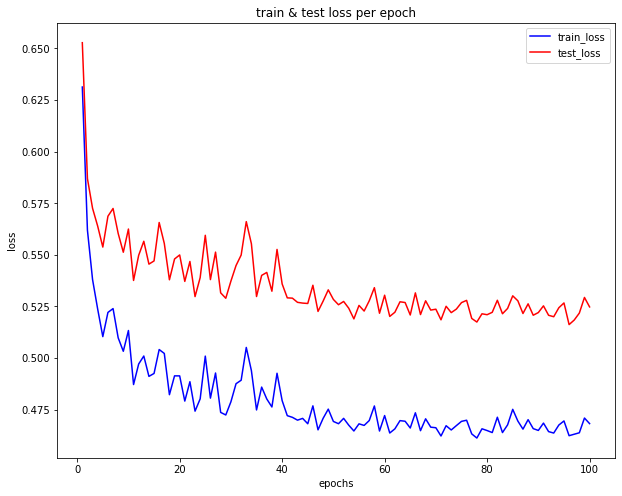

In [18]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

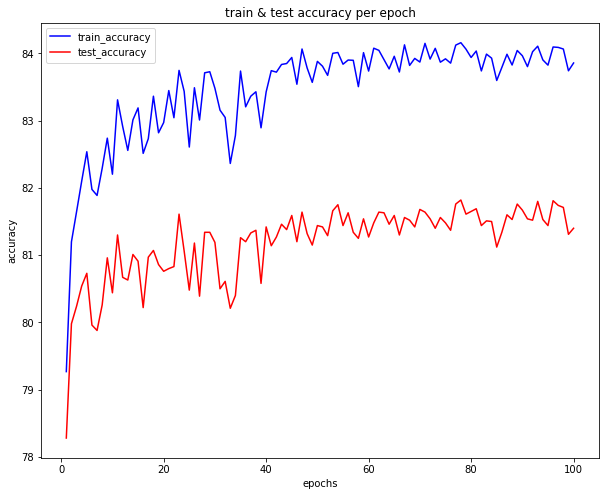

In [19]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [20]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 78
Train: accuracy: 84.2%, avg loss: 0.461243
Test: accuracy: 81.8%, avg loss: 0.517447


## 5.4 Model metrics

In [21]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.84      0.88      0.86      5000
  automobile       0.91      0.93      0.92      5000
        bird       0.81      0.77      0.79      5000
         cat       0.72      0.74      0.73      5000
        deer       0.80      0.78      0.79      5000
         dog       0.83      0.77      0.80      5000
        frog       0.86      0.88      0.87      5000
       horse       0.84      0.85      0.84      5000
        ship       0.90      0.91      0.90      5000
       truck       0.90      0.90      0.90      5000

    accuracy                           0.84     50000
   macro avg       0.84      0.84      0.84     50000
weighted avg       0.84      0.84      0.84     50000

Test:
              precision    recall  f1-score   support

    airplane       0.82      0.84      0.83      1000
  automobile       0.89      0.91      0.90      1000
        bird       0.77      0.74      0.76      1000
         ca

<AxesSubplot:>

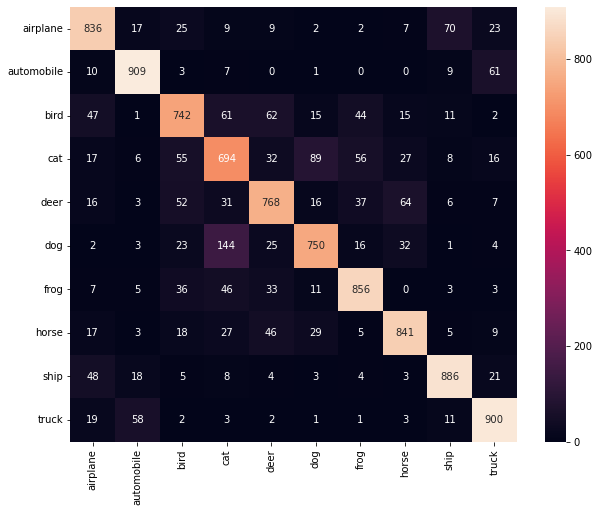

In [22]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [23]:
torch.save(best_model_state_dict, '../saved-model/googlenet-weights.pth')